# Tweet Analysis Notebook

In [1]:
%matplotlib inline

from datetime import datetime
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import src.tweet_func as t
from collections import Counter 
import nltk
from nltk.corpus import stopwords
import scipy as sp
import scipy.stats as stats
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
import plotly.graph_objects as go
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(22, 12)})

import six
%matplotlib inline
plt.style.use('ggplot')

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
def process_tweets(df, *args):
    """process tweet data by applying filters specified in args.
    choices are:
        get_mentions     = create column with @twitter_user mentions
        get_hashtags     = create column with #hashtag(s)
        split_tweets     = create column with a list of words from tweet
        lowercase        = force all letters to lowercase in split_tweets list
        remove_nonalpha  = removes special characters and numbers from list
        remove_stopwords = removes common words referencing stop_words list
        
        return: processed dataframe"""
    
    if 'lowercase' in args:
        df['cleaned_tweets'] = df['tweets'].str.lower()
    if 'get_mentions' in args:
        df['mentions'] = df['cleaned_tweets'].str.findall(r'@.*?(?=\s|$)')
        df['mentions'] = df['mentions'].apply(lambda x: t.clean_tags(x))
    if 'get_hashtags' in args:
        df['hashtags'] = df['cleaned_tweets'].str.findall(r'#.*?(?=\s|$)')
        df['hashtags'] = df['hashtags'].apply(lambda x: t.clean_tags(x))
    if 'remove_mentions' in args:
        df['cleaned_tweets'] = df['cleaned_tweets'].apply(lambda x: t.remove_phrase(x, '@'))
    if 'remove_hashtags' in args:
        df['cleaned_tweets'] = df['cleaned_tweets'].apply(lambda x: t.remove_phrase(x, '#'))
    if 'remove_http' in args:
        df['cleaned_tweets'] = df['cleaned_tweets'].apply(lambda x: t.remove_phrase(x, 'http'))
    if 'remove_nonalpha' in args:
        df['cleaned_tweets'] = df['cleaned_tweets'].apply(lambda x: t.filter_out_nonalpha(x))
    if 'remove_stopwords' in args:
        df['cleaned_tweets'] = df['cleaned_tweets'].apply(lambda x: t.remove_stopwords(x, stop_words))
    if 'split_tweets' in args:
        df['split_tweets'] = df['cleaned_tweets'].str.split(' ')
        df['split_tweets'] = df['split_tweets'].apply(lambda x: list(t.remove_empties(x)))
    # change date/times to datetime
    df['created_at'] = df['created_at'].apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))
    return df

### Read in and process dataset

In [3]:
df = pd.read_csv('data/senators.csv', encoding = "ISO-8859-1")
stop_words = set(stopwords.words('english'))
df.rename(columns={"text": "tweets"}, inplace=True)
# separate tweets into retweet dataframe and non-retweet dataframe
retweets_df = df.copy()[df['tweets'].str.contains('RT @')]
tweets_df = df[~df["tweets"].str.contains('RT @')]
tweets_df = process_tweets(tweets_df,
                           'lowercase',
                           'get_mentions',
                           'get_hashtags', 
                           'remove_mentions', 
                           'remove_hashtags',
                           'remove_http',
                           'remove_nonalpha', 
                           'remove_stopwords',
                           'split_tweets' 
                          )
retweets_df = process_tweets(retweets_df,
                           'lowercase',
                           'get_mentions',
                           'get_hashtags', 
                           'remove_mentions', 
                           'remove_hashtags',
                           'remove_http',
                           'remove_nonalpha', 
                           'remove_stopwords',
                           'split_tweets' 
                          )
tweets_df = tweets_df.set_index('created_at')
tweets_df['unhashedtags'] = tweets_df['hashtags'].apply(lambda x: list(map(t.filter_out_nonalpha, x)))

### NLP, Sentiment Analysis

In [4]:
tweets_df['sentiment'] = tweets_df['cleaned_tweets'].apply(lambda tweet: TextBlob(tweet).sentiment)
tweets_df['polarity'] = tweets_df['sentiment'].apply(lambda x: x.polarity)
tweets_df['polarity_state'] = tweets_df['polarity'].apply(lambda x: t.tweet_sentiment(x))

#### Separate tweets by party

In [5]:
D_tweets_df = tweets_df[tweets_df['party'] == 'D']
R_tweets_df = tweets_df[tweets_df['party'] == 'R']
I_tweets_df = tweets_df[tweets_df['party'] == 'I']

In [6]:
r_total_tweets = R_tweets_df['tweets'].count()
d_total_tweets = D_tweets_df['tweets'].count()

In [7]:
r_count = R_tweets_df.groupby('polarity_state')['polarity_state'].count()
d_count = D_tweets_df.groupby('polarity_state')['polarity_state'].count()

#### NLP

In [12]:
tweets_df.shape

(242213, 17)

In [11]:
tweets_df.memory_usage()

Index             1937704
tweets            1937704
url               1937704
replies           1937704
retweets          1937704
favorites         1937704
user              1937704
bioguide_id       1937704
party             1937704
state             1937704
cleaned_tweets    1937704
mentions          1937704
hashtags          1937704
split_tweets      1937704
unhashedtags      1937704
sentiment         1937704
polarity          1937704
polarity_state    1937704
dtype: int64

In [9]:
cv = CountVectorizer()
cv_fit=cv.fit_transform(tweets_df['cleaned_tweets'])

vocab_cv = cv.get_feature_names()
vocab_count = cv_fit.toarray().sum(axis=0)

MemoryError: Unable to allocate 147. GiB for an array with shape (242213, 81622) and data type int64

#### Sentiment Analysis

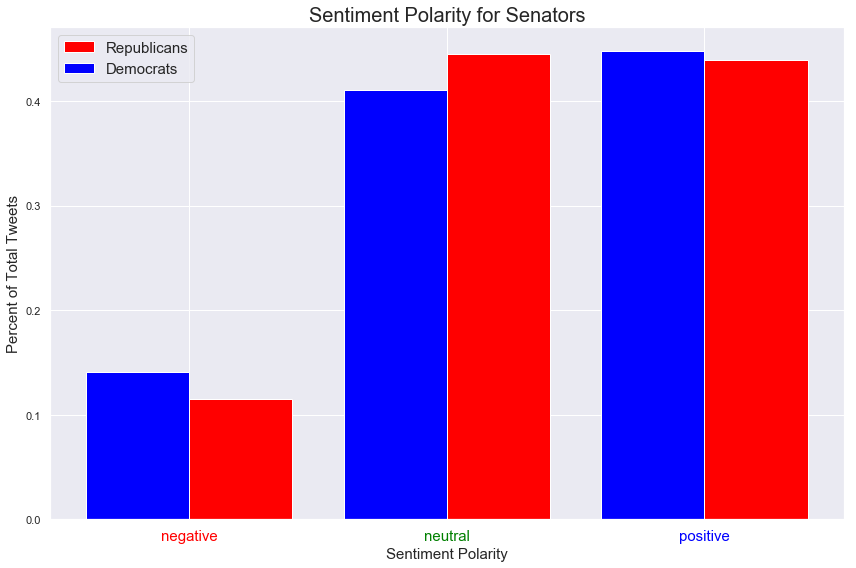

In [20]:
x = np.arange(len(r_count))
width = 0.4

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(x+width/2, r_count/r_total_tweets, width, color='red', label='Republicans')
ax.bar(x-width/2, d_count/d_total_tweets, width, color='blue', label='Democrats')
ax.set_xticks(x)
ax.set_xticklabels(r_count.index, fontsize=15)
ax.set_xlabel('Sentiment Polarity', fontsize =15)
ax.set_ylabel('Percent of Total Tweets', fontsize=15)
ax.set_title('Sentiment Polarity for Senators', fontsize=20)
ax.legend(fontsize=15)
[t.set_color(i) for (i,t) in
 zip(['red','green','blue'],ax.xaxis.get_ticklabels())]
# ax.grid(False)
# plt.savefig('images/Polarity_count.png')
plt.tight_layout()

In [21]:
D_users = D_tweets_df.groupby('user')
d_mean = D_users.mean()
R_users = R_tweets_df.groupby('user')
r_mean = R_users.mean()

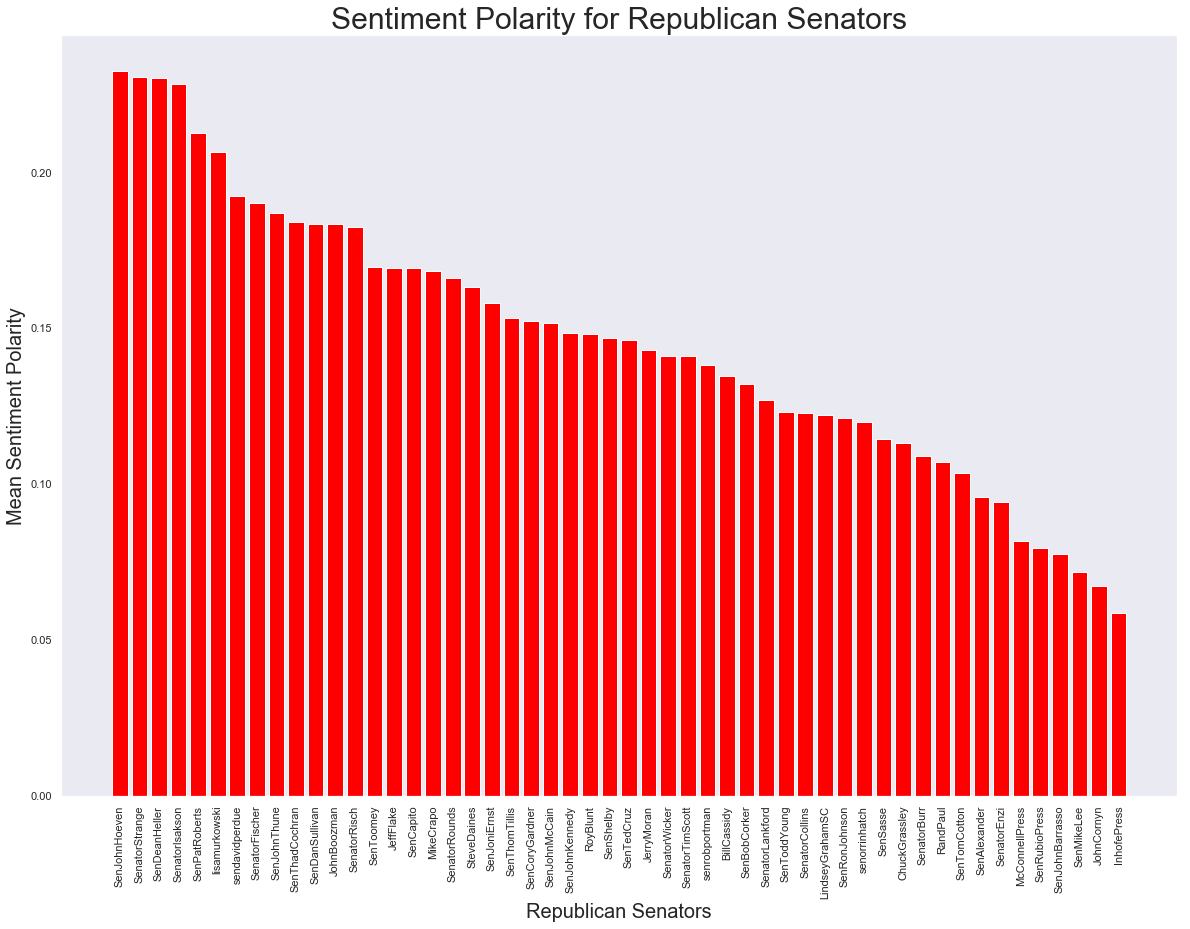

In [22]:
r_sorted = r_mean['polarity'].sort_values(ascending=False)
# x will be the left hand edge of the bars.
x = np.arange(len(r_sorted))

fig, ax = plt.subplots(figsize=(20,14))

bars = ax.bar(x, r_sorted, color='red')
# Make the ticks at the center of the bar using:
#   center = left_edge + 0.5*width
ax.set_xticks(x)
ax.set_xticklabels(r_sorted.index, rotation=90)
ax.set_xlabel('Republican Senators', fontsize =20)
ax.set_ylabel('Mean Sentiment Polarity', fontsize=20)
ax.set_title('Sentiment Polarity for Republican Senators', fontsize=30)
ax.grid(False)
plt.show()

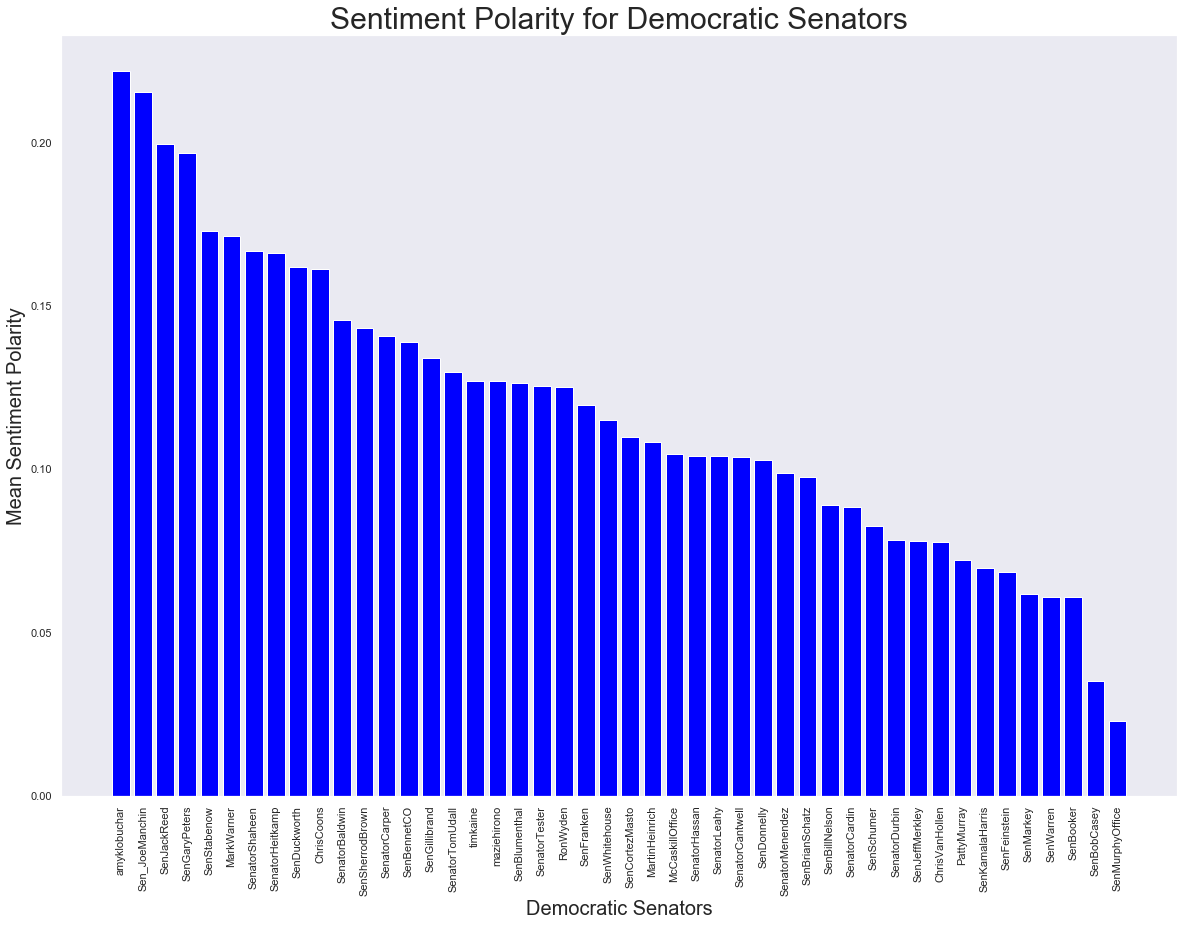

In [23]:
d_sorted = d_mean['polarity'].sort_values(ascending=False)
# x will be the left hand edge of the bars.
x = np.arange(len(d_sorted))

fig, ax = plt.subplots(figsize=(20,14))

bars = ax.bar(x, d_sorted, color='blue')
# Make the ticks at the center of the bar using:
#   center = left_edge + 0.5*width
ax.set_xticks(x)
ax.set_xticklabels(d_sorted.index, rotation=90)
ax.set_xlabel('Democratic Senators', fontsize =20)
ax.set_ylabel('Mean Sentiment Polarity', fontsize=20)
ax.set_title('Sentiment Polarity for Democratic Senators', fontsize=30)
ax.grid(False)
plt.show()

In [24]:
D_all_words = []
for i in D_tweets_df['split_tweets']:
    for j in i:
        D_all_words.append(j)
R_all_words = []
for i in R_tweets_df['split_tweets']:
    for j in i:
        R_all_words.append(j)
        
d_word_count = t.count_dictionary(D_all_words)
r_word_count = t.count_dictionary(R_all_words)
d_top_words = [i[0] for i in Counter(d_word_count).most_common(15)]
r_top_words = [i[0] for i in Counter(r_word_count).most_common(15)]

d_top_polarity = dict()
for word in d_top_words:
    d_top_polarity[word] = TextBlob(word).sentiment.polarity
r_top_polarity = dict()
for word in r_top_words:
    r_top_polarity[word] = TextBlob(word).sentiment.polarity
    
# polarity of top words for each party
print(d_top_polarity,'\n')
print(r_top_polarity)

{'today': 0.0, 'health': 0.0, 'bill': 0.0, 'w': 0.0, 'great': 0.8, 'care': 0.0, 'us': 0.0, 'must': 0.0, 'senate': 0.0, 'need': 0.0, 'help': 0.0, 'work': 0.0, 'new': 0.13636363636363635, 'would': 0.0, 'families': 0.0} 

{'today': 0.0, 'great': 0.8, 'w': 0.0, 'senate': 0.0, 'us': 0.0, 'bill': 0.0, 'help': 0.0, 'watch': 0.0, 'thanks': 0.2, 'new': 0.13636363636363635, 'work': 0.0, 'live': 0.13636363636363635, 'hearing': 0.0, 'act': 0.0, 'support': 0.0}


Examples of Republican tweets with a polarity of 1.0 (highest)

In [25]:
for tweet in R_tweets_df[R_tweets_df['polarity'] == 1.0]['tweets'][:10]:
    print(tweet, '\n------------------------------------------------------------------------------------------------')

Today, my wife &amp; I celebrate our 28th wedding anniversary. She's my best friend &amp; most trusted advisor. I am blesseäó_ https://t.co/wbCrPuiagI 
------------------------------------------------------------------------------------------------
It was a pleasure to have @MissLAUSA stop by my office, along with @MissSCUSA and @MissALUSA. Wishing them the bestäó_ https://t.co/RNHfi1RpW9 
------------------------------------------------------------------------------------------------
Repeal Obamacare, provide replacement, give states/individuals power to decide what works best for them. #ReplaceNow https://t.co/yL4KuUwjZm 
------------------------------------------------------------------------------------------------
These skyrocketing prices are out of control. Time to ditch #Obamacare for The World's Greatest Health Care Plan. https://t.co/3fRmtTDx5z 
------------------------------------------------------------------------------------------------
90% of NC counties have ONE insuran

Examples of Democrat tweets with a polarity of 1.0 (highest)

In [26]:
for tweet in D_tweets_df[D_tweets_df['polarity'] == 1.0]['tweets'][:10]:
    print(tweet, '\n------------------------------------------------------------------------------------------------')

It's the perfect time for apple picking äóñ and MN is the perfect place to do it! https://t.co/pl2p6AKRyf 
------------------------------------------------------------------------------------------------
Congrats to two "Best MN Summer Photo" winners Chris Olson of Fergus Falls &amp; Jon Langan of Menahga whose photos recäó_ https://t.co/vpMIzUVwet 
------------------------------------------------------------------------------------------------
The Tour de France is going on, but the greatest bicyclists are the Minnesotans biking to save lives this week. https://t.co/f4eGuJU8nn 
------------------------------------------------------------------------------------------------
.@SenThomTillis &amp; I led call for Admin to fund research into burn pit exposure. Our vets deserve the best. https://t.co/pBzZUHOS7n 
------------------------------------------------------------------------------------------------
Congrats to MN arboretum staff, volunteers &amp; supporters! Minnesota Arboretum vot

Examples of Republican tweets with a polarity of -1.0 (lowest)

In [27]:
for tweet in R_tweets_df[R_tweets_df['polarity'] == -1.0]['tweets'][:10]:
    print(tweet, '\n------------------------------------------------------------------------------------------------')

Devastating to see the #laflood damage at Denham Springs HS. Will continue to fight for the resources needed to rebäó_ https://t.co/CK7iGnQdxP 
------------------------------------------------------------------------------------------------
The no-fly list is a terrible tool for gun control, in part because it is a terrible tool @washingtonpost https://t.co/rBGqU9Aayk 
------------------------------------------------------------------------------------------------
Please join Laura and me in praying for the individuals and families affected by the horrible tragedy in Charleston, South Carolina. 
------------------------------------------------------------------------------------------------
Executive Amnesty: Another terrible Obama policy rubber-stamped by Landrieu. Help stop them-&gt; http://t.co/gf6Cvc84xG http://t.co/aIde5giJBC 
------------------------------------------------------------------------------------------------
Executive Amnesty: Another terrible Obama policy rubber-sta

Examples of Democrat tweets with a polarity of -1.0 (lowest)

In [28]:
for tweet in D_tweets_df[D_tweets_df['polarity'] == -1.0]['tweets'][:10]:
    print(tweet, '\n------------------------------------------------------------------------------------------------')

My thoughts today on the horrible tragedy in Las Vegas: https://t.co/1mh84euvSQ 
------------------------------------------------------------------------------------------------
The victims of this terrible shooting, their families, &amp; the people of Las Vegas are in our prayers &amp; hearts today. 
------------------------------------------------------------------------------------------------
Just took to Senate floor to speak out against this. Outrageous. https://t.co/j8F9QJQiBe 
------------------------------------------------------------------------------------------------
Prayers for Rep. Scalise, aides, law enforcement, and all those who were hurt. No words to describe how terrible this is. 
------------------------------------------------------------------------------------------------
'Nasty' storm hits Twin Cities, still 70,000 without power https://t.co/v7HCf83iSx 
------------------------------------------------------------------------------------------------
United hasn'

In [29]:
tweets_df[tweets_df['polarity'] == tweets_df['polarity'].min()][['tweets', 'user', 'party', 'polarity']][:800:90]

tweets  \
created_at                                                               
2017-10-02 21:25:00  My thoughts today on the horrible tragedy in L...   
2017-06-28 18:07:00  Grant dollars for the #opioidepidemic wonäó»t ...   
2016-06-07 20:05:00  #Opioidepidemic is devastating lives, families...   
2016-04-05 14:11:00  Our thoughts and prayers are with the victims ...   
2015-04-27 17:27:00  My thoughts are w/ the people of #Nepal as sea...   
2014-07-22 18:22:00  The atrocities against Iraqi Christians are de...   
2015-10-27 13:15:00  Sen. Gardner at @SAISHopkins: "The world must ...   
2017-02-17 16:39:00  That the Trump admin would even consider a pla...   
2017-05-03 17:34:00  3 million Bay Staters under 65 have pre-existi...   

                                user party  polarity  
created_at                                            
2017-10-02 21:25:00     amyklobuchar     D      -1.0  
2017-06-28 18:07:00   MartinHeinrich     D      -1.0  
2016-06-07 20:05:00         RoyBlunt     R      -1.0  
2016-04-05 14:11:00    SenatorCarper     D      -1.0  
2015-04-27 17:27:00  SenatorLankford     R      -1.0  
2014-07-22 18:22:00    SenatorWicker     R      -1.0  
2015-10-27 13:15:00   SenCoryGardner     R      -1.0  
2017-02-17 16:39:00    SenGillibrand     D      -1.0  
2017-05-03 17:34:00        SenMarkey     D      -1.0

In [30]:
tweets_df[tweets_df['polarity'] == 1.0][['tweets', 'user', 'party', 'polarity']][:1600:160]

tweets  \
created_at                                                               
2017-10-08 17:41:00  It's the perfect time for apple picking äóñ an...   
2017-07-08 02:37:00  Choice is Obamacare or best efforts to stabili...   
2017-07-20 01:22:00  Counting on the legendary John McCain strength...   
2016-07-21 14:37:00  One of the best pieces of advice I was given a...   
2015-04-30 15:31:00  #MODGourmetGalaäó»s Best in Show Award went to...   
2014-07-23 17:02:00  VIDEO: The proposed EPA rule for existing powe...   
2017-08-11 20:04:00  .@AUG_Chronicle: RAISE Act takes America's bes...   
2014-06-15 13:07:00  Happyæ#FathersDayæto dads everywhere! Here's...   
2017-08-04 16:52:00  During #AmericanDreamWeek, we want to highligh...   
2017-07-26 16:22:00  Excellent news äóñ best wishes to Steve as he ...   

                               user party  polarity  
created_at                                           
2017-10-08 17:41:00    amyklobuchar     D       1.0  
2017-07-08 02:37:00      JohnCornyn     R       1.0  
2017-07-20 01:22:00        RonWyden     D       1.0  
2016-07-21 14:37:00   SenatorCarper     D       1.0  
2015-04-30 15:31:00  SenatorIsakson     R       1.0  
2014-07-23 17:02:00   SenatorWicker     R       1.0  
2017-08-11 20:04:00  sendavidperdue     R       1.0  
2014-06-15 13:07:00     SenJackReed     D       1.0  
2017-08-04 16:52:00   senorrinhatch     R       1.0  
2017-07-26 16:22:00      SenTedCruz     R       1.0

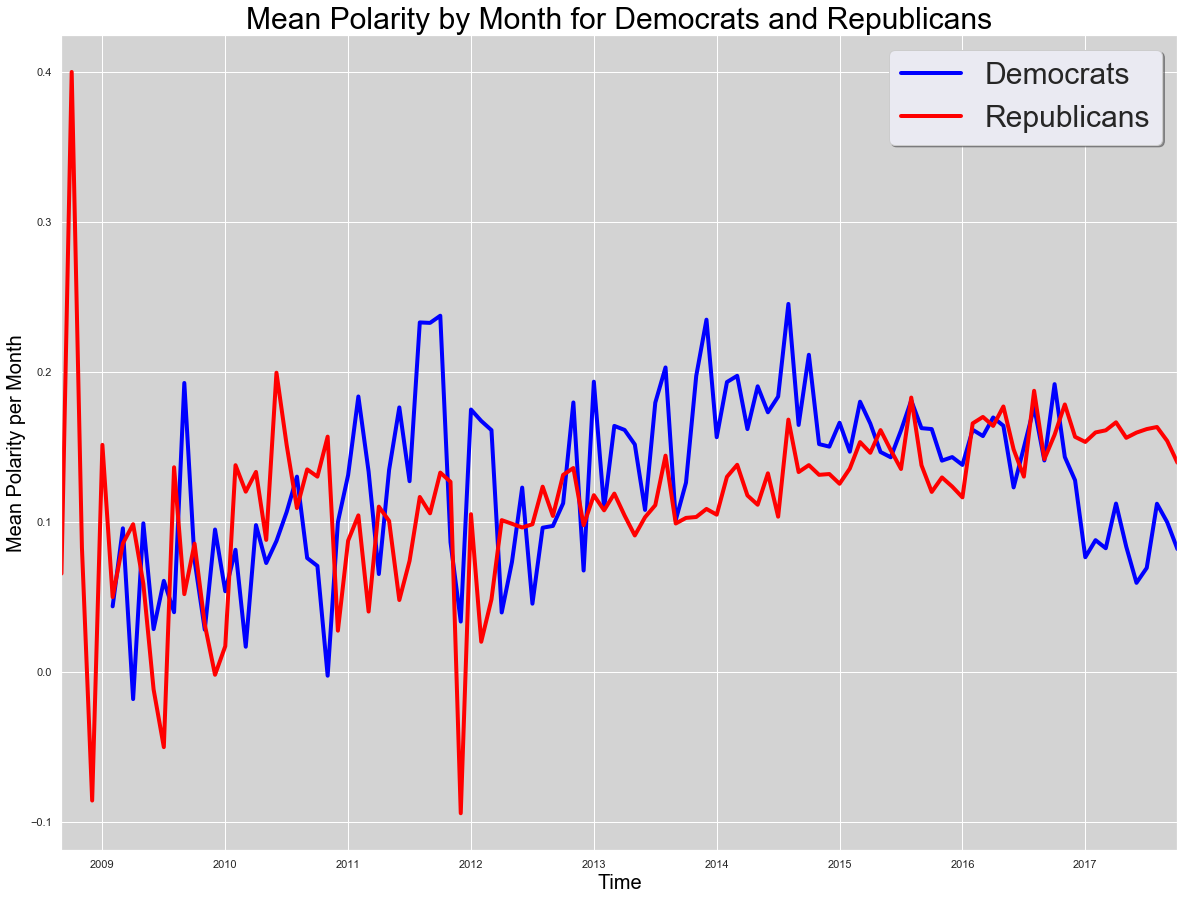

In [31]:
dgb_p = D_tweets_df.groupby([pd.Grouper(freq="M")]).mean()['polarity']
rgb_p = R_tweets_df.groupby([pd.Grouper(freq="M")]).mean()['polarity']

fig, ax = plt.subplots(figsize=(20,15))
ax.set_facecolor('lightgrey')
dgb_p.plot(color='blue', label='Democrats', linewidth=4)
rgb_p.plot(color='red', label='Republicans', linewidth=4)
plt.legend(fontsize=30, shadow=True)
# legend = plt.legend(fontsize=30)
ax.set_xlabel('Time', fontsize =20, color='black')
ax.set_ylabel('Mean Polarity per Month', fontsize=20, color='black')
ax.set_title('Mean Polarity by Month for Democrats and Republicans', fontsize=30, color='black')
plt.savefig('images/polarity_per_month_RandD.png')
plt.show()

### Plot mean monthly tweets for all senators

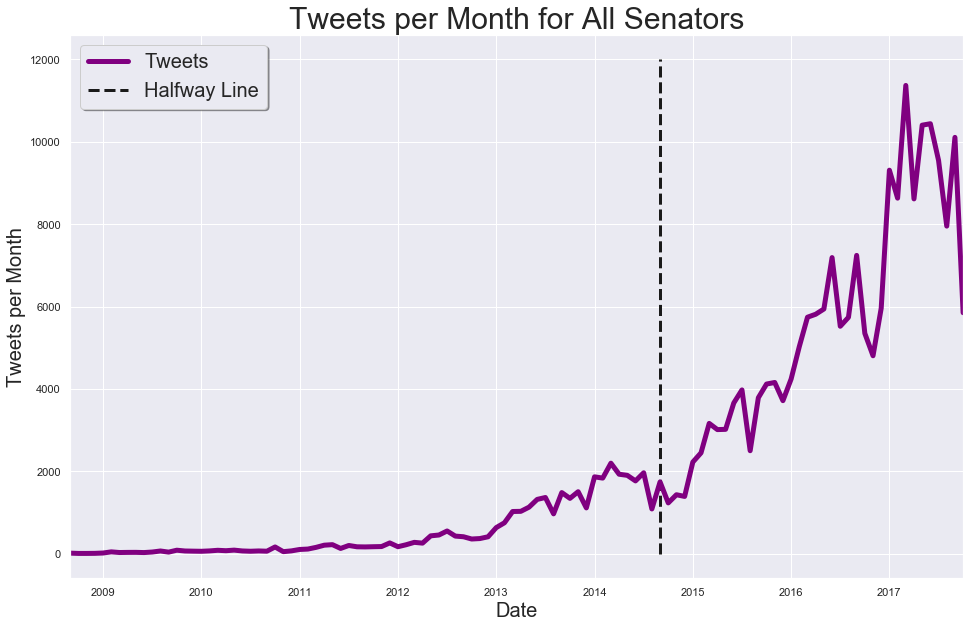

In [32]:
fig, ax = plt.subplots(figsize=(16,10))
tweets_df.groupby([pd.Grouper(freq='M')])['tweets'].count().plot(legend=False, linewidth=5, color='purple', label='Tweets')
plt.title('Tweets per Month for All Senators', fontsize=30)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Tweets per Month', fontsize=20)
plt.vlines('2014-09-04 23:22:00', 0, 12000, linewidth=3, linestyles='--', label='Halfway Line')
plt.legend(shadow=True, loc='upper left', fontsize=20)
plt.savefig('images/Half_tweets.png')
plt.show()

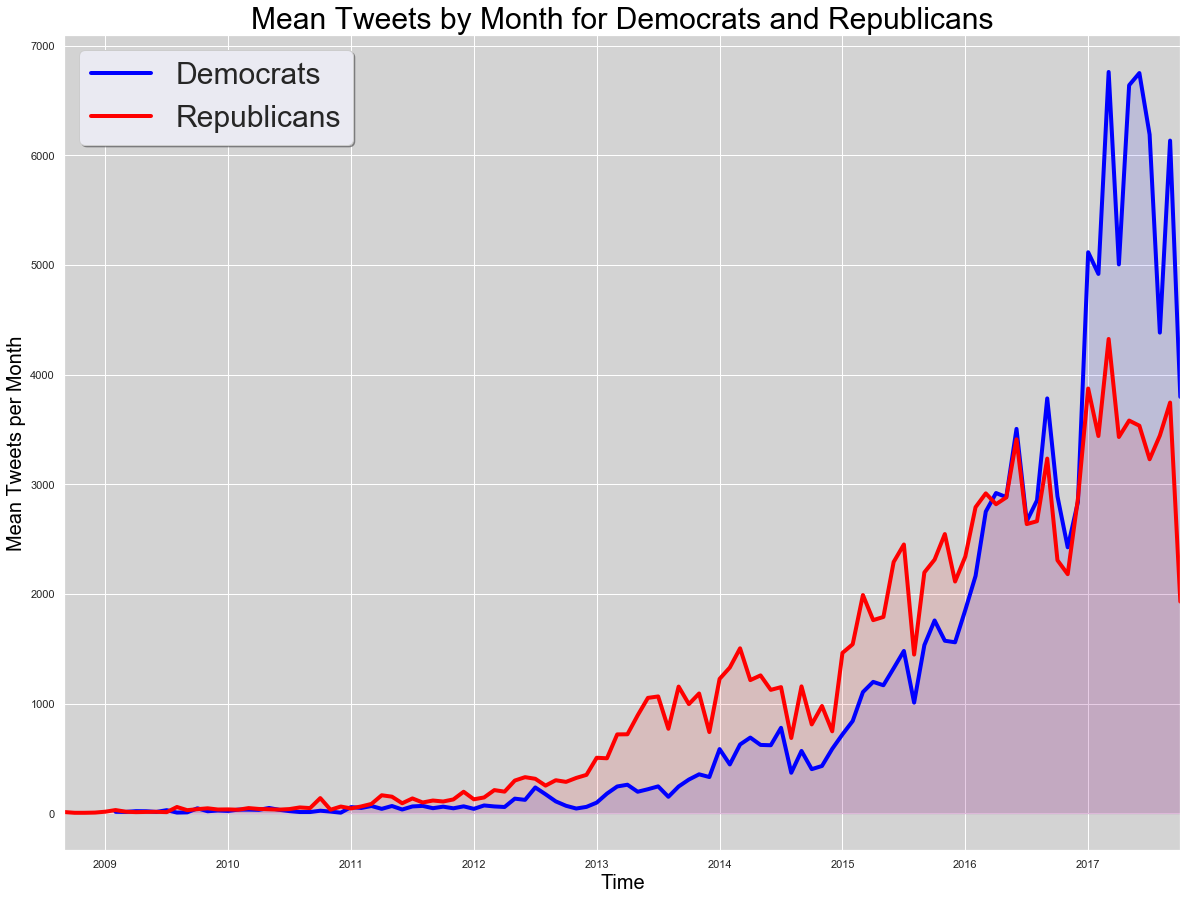

In [33]:
dbm = D_tweets_df.groupby([pd.Grouper(freq="M")]).count()['tweets']
rbm = R_tweets_df.groupby([pd.Grouper(freq="M")]).count()['tweets']

fig, ax = plt.subplots(figsize=(20,15))
ax.set_facecolor('lightgrey')
dbm.plot(color='blue', label='Democrats', linewidth=4)
rbm.plot(color='red', label='Republicans', linewidth=4)
plt.legend(fontsize=30, shadow=True)
ax.set_xlabel('Time', fontsize =20, color='black')
ax.set_ylabel('Mean Tweets per Month', fontsize=20, color='black')
ax.set_title('Mean Tweets by Month for Democrats and Republicans', fontsize=30, color='black')
ax.fill_between(x=dbm.index,
                    y1=dbm.values,
                    y2=[0] * len(dbm),
                    color='blue',
                    alpha=0.1)
ax.fill_between(x=rbm.index,
                    y1=rbm.values,
                    y2=[0] * len(rbm),
                    color='red',
                    alpha=0.1)
plt.savefig('images/tweets_per_month_RD.png')
plt.show()

How many tweets are retweets?

In [34]:
print(f'shape of tweets dataframe: {tweets_df.shape}')
print(f'shape of retweets dataframe: {retweets_df.shape}')
print(f'percent not retweets: {len(tweets_df)/len(df):2.2f}')
print(f'percent retweets: {len(retweets_df)/len(df):2.2f}')

shape of tweets dataframe: (242213, 17)
shape of retweets dataframe: (46402, 14)
percent not retweets: 0.84
percent retweets: 0.16


## Geographical Plots for mean tweets and sentiment

### Tweet Counts per State

In [35]:
def plotly_usa(df, title, colorbar_title, agg_type='ct', color_scale='greens', scaled=False, scale_range='M', reverse_scale=False):
    num = ((df.index.max() - df.index.min())/np.timedelta64(1, scale_range))
    if agg_type == 'ct':
        grouped_df = df.groupby(['state']).count()['polarity']
    elif agg_type == 'mn':
        grouped_df = df.groupby(['state']).mean()['polarity']
    if scaled:
        grouped_df = grouped_df/num
    fig = go.Figure(data=go.Choropleth(
        locations=grouped_df.index, # Spatial coordinates
        z = grouped_df, # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = color_scale,
        colorbar_title = colorbar_title,
        reversescale = reverse_scale,
    ))

    fig.update_layout(
        title_text = title,
        geo_scope='usa', # limite map scope to USA
    )

    fig.show()

In [36]:
plotly_usa(R_tweets_df, 'Republican Tweets per Month By State', "Mean Monthly Tweets", agg_type='ct', color_scale='reds', scaled=True)

In [37]:
plotly_usa(D_tweets_df, 'Democrat Tweets per Month By State', "Mean Monthly Tweets", agg_type='ct', color_scale='blues', scaled=True)

In [38]:
plotly_usa(tweets_df, 'Tweet Count By State (both parties)', 'Mean Monthly Tweets', agg_type='ct', color_scale='purples', scaled=True)

### Mean Polarity per State

In [39]:
plotly_usa(R_tweets_df, 'Mean Republican Polarity By State', 'Mean Polarity', agg_type='mn', color_scale='reds')

In [40]:
plotly_usa(D_tweets_df, 'Mean Democrat Polarity By State', 'Mean Polarity', agg_type='mn', color_scale='blues')

In [41]:
plotly_usa(tweets_df, 'Mean Polarity By State (both parties)', 'Mean Polarity', agg_type='mn', color_scale='purples')

### Mean Polarity > 0.6

In [42]:
plotly_usa(R_tweets_df[R_tweets_df['polarity'] > 0.6], 'Mean Republican Polarity By State', 'Mean Polarity', agg_type='mn', color_scale='reds')

In [43]:
plotly_usa(D_tweets_df[D_tweets_df['polarity'] > 0.6], 'Mean Democrat Polarity By State', 'Mean Polarity', agg_type='mn', color_scale='blues')

In [44]:
plotly_usa(tweets_df[tweets_df['polarity'] > 0.6], 'Mean Polarity By State', 'Mean Polarity', agg_type='mn', color_scale='purples')

### Mean Polarity < -0.6

In [45]:
plotly_usa(R_tweets_df[R_tweets_df['polarity'] < -0.6], 'Mean Republican Polarity By State', 'Mean Polarity', agg_type='mn', color_scale='reds', reverse_scale=True)

In [46]:
plotly_usa(D_tweets_df[D_tweets_df['polarity'] < -0.6], 'Mean Democrat Polarity By State', 'Mean Polarity', agg_type='mn', color_scale='blues', reverse_scale=True)

In [47]:
plotly_usa(tweets_df[tweets_df['polarity'] < -0.6], 'Mean Polarity By State', 'Mean Polarity', agg_type='mn', color_scale='purples', reverse_scale=True)

## Wordclouds

### Hashtags

In [55]:
# create masks
republican_mask = np.array(Image.open("images/republican_mask.png"))
democrat_mask = np.array(Image.open("images/democrat_mask.png"))

In [56]:
D_hashtags = ''
for tags in D_tweets_df['unhashedtags']:
    if len(tags) != 0:
        for tag in tags:
            D_hashtags += ' '
            D_hashtags += tag
R_hashtags = ''
for tags in R_tweets_df['unhashedtags']:
    if len(tags) != 0:
        for tag in tags:
            R_hashtags += ' '
            R_hashtags += tag

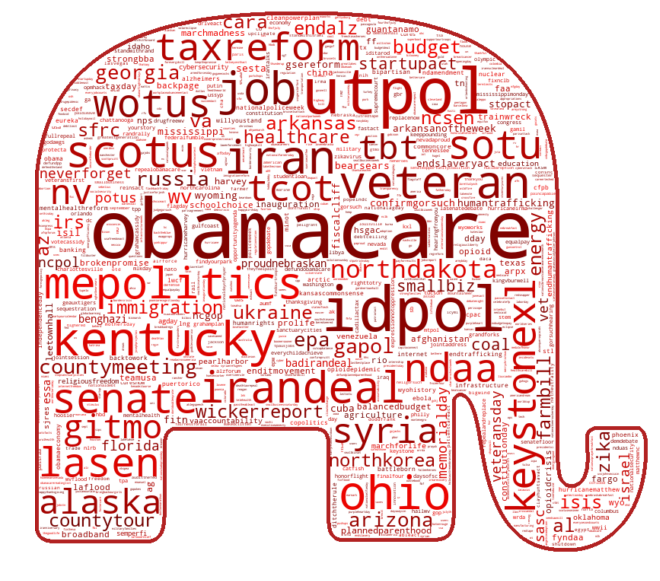

In [57]:
# generate word cloud from republican hashtags
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 1.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

wc = WordCloud(background_color="white", max_words=1000, mask=republican_mask,
               contour_width=6, collocations=False, contour_color='firebrick', color_func=random_color_func)

# Generate a wordcloud
wc.generate(R_hashtags)

# store to file
wc.to_file("images/republican_hashtags.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

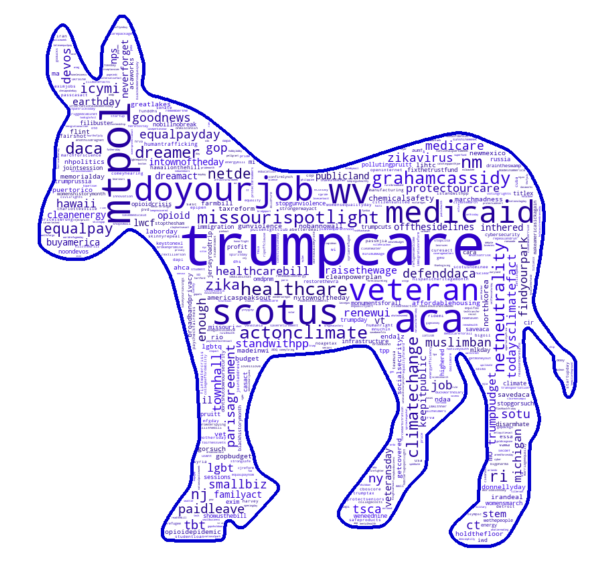

In [58]:
# generate word cloud from republican hashtags
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 180.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

wc = WordCloud(background_color="white", max_words=1000, mask=democrat_mask,
               contour_width=6, collocations=False, contour_color='mediumblue', color_func=random_color_func)

# Generate a wordcloud
wc.generate(D_hashtags)

# store to file
wc.to_file("images/democrat_hashtags.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Words in tweets

In [59]:
# get word lists
tweets = [i for i in D_tweets_df['cleaned_tweets']]
D_words = ''.join(tweets)
tweets = [i for i in R_tweets_df['cleaned_tweets']]
R_words = ''.join(tweets)

In [60]:
# create masks
republican_mask = np.array(Image.open("images/republican_mask.png"))
democrat_mask = np.array(Image.open("images/democrat_mask.png"))

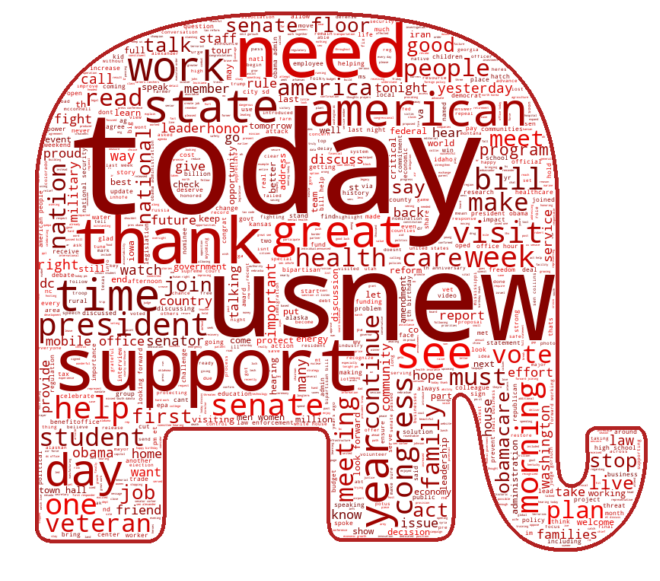

In [61]:
# generate word cloud from republican tweet
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 1.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

wc = WordCloud(background_color="white", max_words=1000, mask=republican_mask,
               contour_width=6, contour_color='firebrick', color_func=random_color_func)

# Generate a wordcloud
wc.generate(R_words)

# store to file
wc.to_file("images/republican_words.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

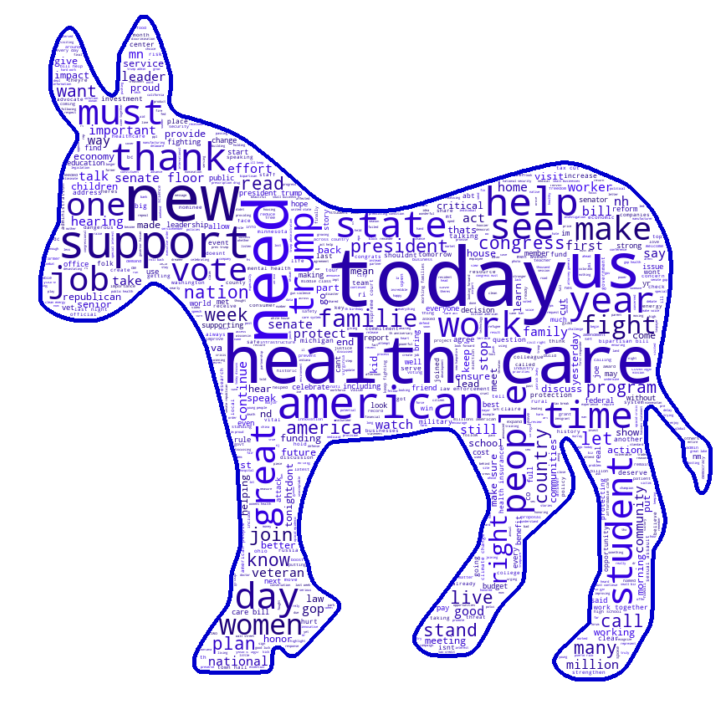

In [62]:
# generate word cloud from democrat tweets
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 180.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

wc = WordCloud(background_color="white", max_words=1000, mask=democrat_mask,
               contour_width=6, contour_color='mediumblue', color_func=random_color_func)

# Generate a wordcloud
wc.generate(D_words)

# store to file
wc.to_file("images/democratic_words.png")

# show
plt.figure(figsize=[25,12.5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()